Import cleaned csv with all features included

In [68]:
import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import log_loss, roc_auc_score, brier_score_loss

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    log_loss, roc_auc_score, brier_score_loss, accuracy_score, f1_score
)
import matplotlib.pyplot as plt

import pandas as pd

path = "../intermediate/schedules_cleaned.csv"

df_raw = pd.read_csv(path)

Delete any columns that would leak data from present or future games

In [69]:
leakage_cols = [
    # direct outcomes
    "home_score", "away_score", "team_score", "opp_score", 
    "point_diff", "Winner",

    # current team stats (not prior)
    "team_fga", "team_fgm", "team_first_down", "team_fumbles_lost",
    "team_pass_att", "team_pass_cmp", "team_pass_int",
    "team_pass_sacked", "team_pass_td", "team_pass_yds",
    "team_penalties", "team_penalties_yds",
    "team_plays_offense",
    "team_rush_att", "team_rush_td", "team_rush_yds",
    "team_turnovers",
    "team_xpa", "team_xpm",
    "team_punt", "team_punt_yds",
    "team_pass_sacked_yds",

    # current opponent stats (not prior)
    "opp_fga", "opp_fgm", "opp_first_down", "opp_fumbles_lost",
    "opp_pass_att", "opp_pass_cmp", "opp_pass_int",
    "opp_pass_sacked", "opp_pass_td", "opp_pass_yds",
    "opp_penalties", "opp_penalties_yds",
    "opp_plays_offense",
    "opp_rush_att", "opp_rush_td", "opp_rush_yds",
    "opp_turnovers",
    "opp_xpa", "opp_xpm",
    "opp_punt", "opp_punt_yds",
    "opp_pass_sacked_yds"
]

df_work = df_raw.drop(columns=[c for c in leakage_cols if c in df_raw.columns], errors="ignore")

Drop any target rows that are missing a value

In [70]:
# --- 3) Drop rows missing essential fields
print("Missing team_moneyline:", df_work["team_moneyline"].isna().sum())
df_work = df_work.dropna(subset=["team_moneyline"])  # keep if you really want to require this
df_work = df_work.dropna(subset=["team_win"])        # ensure target present

# Ensure binary target
df_work["team_win"] = df_work["team_win"].astype(int)

Missing team_moneyline: 2


In [71]:
# --- 3) Feature selection (numeric only; exclude IDs, text, market, and target)
drop_exact = {
    "team_win","team_prob_novig", "opp_prob_novig", "spread_line", "total_line",
    "team_moneyline","opp_moneyline",      # markets / target-adjacent
    "game_id","team","opponent","home_team","away_team",
    "referee","team_coach","opp_coach","stadium","location",
    "weekday","gametime","game_type","date","Winner",
    # keep season/week in the dataframe for splitting, but don't model them:
    "season","week"
}

num_cols = []
dropped_non_numeric = []

for c in df_work.columns:
    if c in drop_exact:
        continue
    if pd.api.types.is_numeric_dtype(df_work[c]):
        num_cols.append(c)
    else:
        dropped_non_numeric.append(c)

print("Dropped for non-numeric:", dropped_non_numeric)
print(f"Initial numeric feature count: {len(num_cols)}")

# Define X/y now from the working frame, but keep df_work intact for splitting
X_full_all = df_work[num_cols].copy()
y_full_all = df_work["team_win"].values

Dropped for non-numeric: []
Initial numeric feature count: 474


Time split to ensure only pruning learned on training data

In [72]:
# --- 5) Time-based split: last season as test (uses df_work, which still has 'season')
last_season = int(df_work["season"].max())
train_idx = df_work["season"] < last_season
test_idx  = df_work["season"] == last_season

train = df_work.loc[train_idx].copy()
cal   = df_work[df_work["season"] == last_season-1].copy()
test  = df_work.loc[test_idx].copy()

print(f"Train seasons: {sorted(train['season'].unique())}")
print("Cal season   :", sorted(cal["season"].unique()))
print(f"Test season  : {sorted(test['season'].unique())}")
print(f"Train/Test sizes: {len(train)}/{len(test)}")

X_train, y_train = train[num_cols], train["team_win"].values
X_cal,   y_cal   = cal[num_cols],   cal["team_win"].values
X_test,  y_test  = test[num_cols],  test["team_win"].values

Train seasons: [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]
Cal season   : [2023]
Test season  : [2024]
Train/Test sizes: 5448/570


Drop According to Pre Checks

In [ ]:
# --- Pre-screen columns BEFORE pruning
def prescreen_columns(df, miss_thresh=0.80, freq_cut=95/5, unique_cut=0.10):
    drop_reasons = {}

    # --- Missingness
    miss_cols = df.columns[df.isna().mean() > miss_thresh]
    for c in miss_cols:
        drop_reasons[c] = f"Missingness > {miss_thresh:.0%} ({df[c].isna().mean():.1%})"

    # --- Constants & NZV
    for c in df.columns:
        if c in drop_reasons: 
            continue
        s = df[c]
        if s.nunique(dropna=True) <= 1:
            drop_reasons[c] = "Constant (≤1 unique value)"
            continue
        vc = s.value_counts(dropna=True)
        freq_ratio = vc.iloc[0] / (vc.iloc[1] if len(vc) > 1 else 1)
        unique_pct = s.nunique(dropna=True) / len(s)
        if (freq_ratio > freq_cut) and (unique_pct < unique_cut):
            drop_reasons[c] = (f"Near-zero variance: freq_ratio={freq_ratio:.1f}, "
                               f"unique_pct={unique_pct:.1%}")

    # --- Compute actual drop set
    drop_set = set(drop_reasons.keys())
    kept_set = set(df.columns) - drop_set

    # Double-check: if length changed after drop, but reason missing, log as "Other"
    df_after = df.drop(columns=list(drop_set), errors="ignore")
    actually_dropped = set(df.columns) - set(df_after.columns)
    for c in actually_dropped:
        if c not in drop_reasons:
            drop_reasons[c] = "Dropped (unspecified reason)"

    return df_after, drop_reasons

# --- Apply prescreen to TRAIN ONLY (then align TEST to same kept columns)
print("Before prescreen:", len(num_cols), "numeric candidates")

X_train_all, pre_drop = prescreen_columns(X_train_all, miss_thresh=0.80)
print("Pre-screen dropped:", len(pre_drop))
for col, reason in pre_drop.items():
    print(f"{col}: {reason}")

# Update feature list
num_cols = list(X_train_all.columns)

# Align test set to the same features
X_test_all = X_test_all[num_cols].copy()

print("After prescreen:", len(num_cols), "numeric candidates")

Before prescreen: 474 numeric candidates
Pre-screen dropped: 0
After prescreen: 433 numeric candidates


In [74]:
def drop_low_importance(X_train, y_train, keep_top_frac=0.6, min_keep=80, random_state=42):
    model = XGBClassifier(
        n_estimators=2000, learning_rate=0.02, max_depth=6,
        subsample=0.8, colsample_bytree=0.8,
        reg_lambda=1.0, objective="binary:logistic",
        eval_metric="logloss", tree_method="hist",
        random_state=random_state
    )
    model.fit(X_train, y_train, verbose=False)

    cols = list(X_train.columns)
    gain = pd.Series(model.get_booster().get_score(importance_type="gain"))
    gain = gain.reindex(cols).fillna(0.0)

    k = max(min_keep, int(len(cols) * keep_top_frac))
    kept    = gain.sort_values(ascending=False).index[:k].tolist()
    dropped = [c for c in cols if c not in kept]

    print(f"\n⚡ Gain-based pruning: kept {len(kept)}/{len(cols)} | dropped {len(dropped)}")
    if dropped:
        for feat, imp in gain.loc[dropped].sort_values().items():
            print(f" - {feat:35s} {imp:.6f}")

    return kept, dropped, gain

# Learn pruning on TRAIN ONLY
kept_cols, dropped_cols, gain_series = drop_low_importance(
    X_train_all, y_train, keep_top_frac=0.6, min_keep=80, random_state=42
)

# Apply the same columns to train/test
X_train = X_train_all[kept_cols].copy()
X_test  = X_test_all[kept_cols].copy()

print(f"Using {len(kept_cols)} kept numeric features.")


⚡ Gain-based pruning: kept 259/433 | dropped 174
 - must_win_proxy                      0.000000
 - inj_qb_flag                         0.346492
 - temp_bin_61_80                      0.603212
 - roof_dome                           0.970501
 - surface_fieldturf                   1.030930
 - sev_qb_prior1                       1.098580
 - temp_bin_33_60                      1.231633
 - inj_DT_prior1                       1.326563
 - inj_QB_prior1                       1.407605
 - prac_sev_DT                         1.409677
 - inj_ol                              1.435344
 - inj_qb_flag_prior1                  1.455100
 - prac_sev_TE_prior1                  1.471157
 - sev_DT                              1.507795
 - opp_pass_td_prior1                  1.530257
 - wind2                               1.532405
 - inj_C_prior1                        1.560339
 - team_turnovers_roll3                1.588782
 - inj_CB                              1.601513
 - sev_TE_prior1                      

In [75]:
gold = pd.concat(
    [df_work.loc[train_idx | test_idx, ["season","week","game_id"]].reset_index(drop=True),
     pd.concat([X_train_all, X_test_all]).reset_index(drop=True)],
    axis=1
)
gold.to_csv("../gold/schedules_gold_features.csv", index=False)

Train Models to Try and Predict Team win probability, if there is a discreptency between predicted probablity and markett implied porobablitliilyt based on betting lines, place a simulated bet, and see how accurate over the past 10 years it has been.


--- Data Split Summary ---
Train seasons: [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]
Test season : [2024]
Train size  : 5448 rows
Test size   : 570 rows
Features used: 259

[RandomForest]
LogLoss: 0.6428 | AUC: 0.6940 | Brier: 0.2255 | Accuracy: 0.6456 | F1: 0.6622

Top 15 features for RandomForest:
team_win_pct_pre               0.0123
diff_score_roll10              0.0108
opp_score_roll10               0.0087
diff_fd_rate_roll10            0.0085
diff_score_roll5               0.0084
diff_fd_rate_roll5             0.0072
point_diff_roll10              0.0071
opp_score_roll5                0.0068
opp_fd_rate_roll10             0.0067
diff_pass_td_rate_roll10       0.0066
opp_score_season               0.0065
prac_sev_total_mean            0.0064
sev_total_mean                 0.0061
point_diff_roll5               0.0061
opp_pass_td_rate_roll10        0.0061

Bottom 5 features for RandomForest:
surface_sportturf              0.0003
inj_K                          0.00

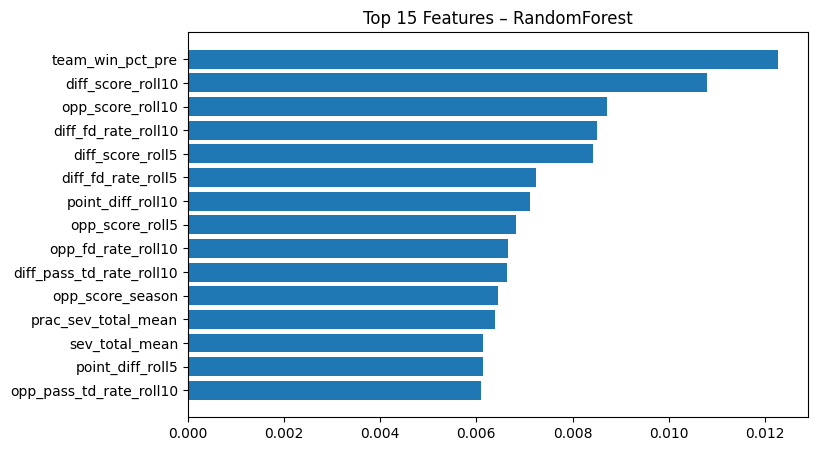


[XGBoost]
LogLoss: 0.7169 | AUC: 0.6775 | Brier: 0.2434 | Accuracy: 0.6263 | F1: 0.6432

Top 15 features for XGBoost:
diff_score_roll10              0.0136
team_win_pct_pre               0.0097
roof_closed                    0.0079
prac_sev_C_prior1              0.0074
opp_pass_sacked_roll10         0.0068
int_is_home__team_win_pct_pre  0.0066
diff_score_roll5               0.0065
inj_K_prior1                   0.0058
temp_bin_gt_80                 0.0057
team_pass_td_prior1            0.0057
diff_turnovers_roll10          0.0056
team_xpm_prior1                0.0056
int_is_home__diff_pass_ypa_roll5 0.0055
team_xpa_prior1                0.0054
late_season                    0.0054

Bottom 5 features for XGBoost:
team_fg_per_play_rate_roll3    0.0024
prac_sev_QB                    0.0024
sev_qb                         0.0021
inj_T                          0.0020
surface_matrixturf             0.0009


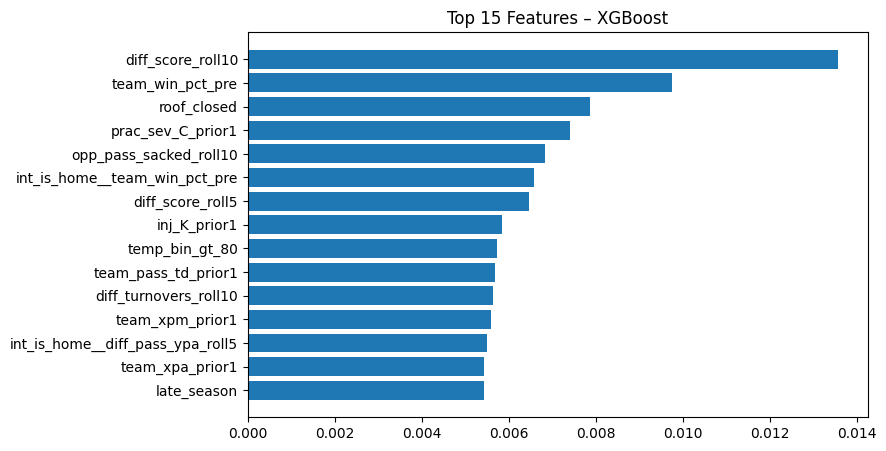


[RF (calibrated)]  LogLoss=0.7034  AUC=0.6893  Brier=0.2268  Acc=0.6526  F1=0.6333


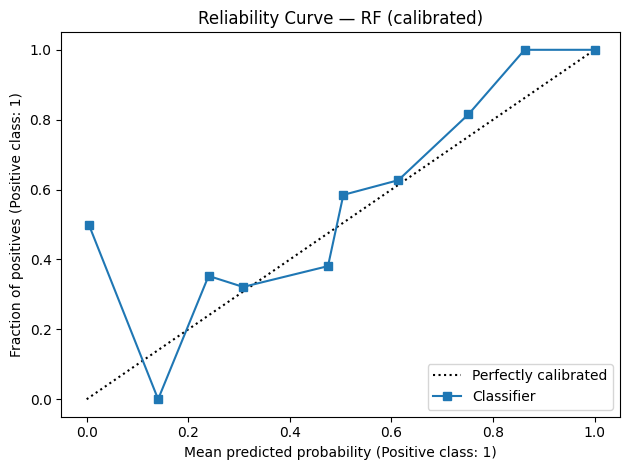


[XGB (calibrated)]  LogLoss=0.7126  AUC=0.6734  Brier=0.2306  Acc=0.6421  F1=0.6165


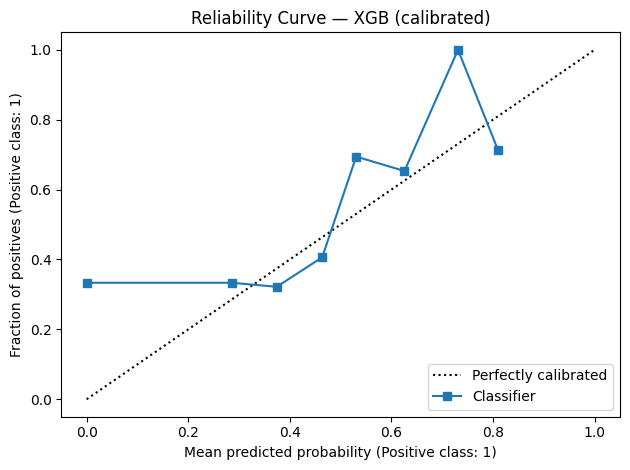

Tuned blend alphas — RF: 0.90, XGB: 0.90

Bets: 153 | P&L: -20.37 | ROI: -0.133 | Hit: 0.359 | Avg edge: 0.168 | Avg stake: 1.00

Bets: 120 | P&L: 2.02 | ROI: 0.017 | Hit: 0.408 | Avg edge: 0.176 | Avg stake: 1.00

Top RF edges:
     season  week team opponent  team_moneyline  team_prob_novig   p_model  \
374    2024     1   NE      CIN           295.0         0.242812  0.688031   
301    2024    18   LA      SEA           285.0         0.249187  0.688669   
360    2024     5  MIN      NYJ          -142.0         0.563492  0.956349   
230    2024    20  HOU       KC           410.0         0.188133  0.570987   
469    2024     7  PIT      NYJ           140.0         0.400361  0.752536   
161    2024     4  DEN      NYJ           330.0         0.223167  0.574491   
541    2024    10  TEN      LAC           300.0         0.240000  0.576174   
552    2024     3  WAS      CIN           280.0         0.252217  0.577396   
398    2024     8   NO      LAC           250.0         0.274247  0.5

In [76]:
# --- 8) Pipelines (use kept_cols)
pre = ColumnTransformer([
    ("num", SimpleImputer(strategy="median"), kept_cols)
], remainder="drop")

rf = Pipeline([
    ("pre", pre),
    ("rf", RandomForestClassifier(
        n_estimators=500, max_depth=None, min_samples_leaf=2, n_jobs=-1, random_state=42
    ))
])

xgb = Pipeline([
    ("pre", pre),
    ("xgb", XGBClassifier(
        n_estimators=800, max_depth=6, learning_rate=0.05, subsample=0.9, colsample_bytree=0.9,
        reg_lambda=1.0, n_jobs=-1, random_state=42, objective="binary:logistic", eval_metric="logloss"
    ))
])

def evaluate_model(pipe, name, show_features=True, top_n=15):
    # Fit
    pipe.fit(X_train, y_train)
    p_test = pipe.predict_proba(X_test)[:, 1]  # probability team wins
    y_pred = (p_test >= 0.5).astype(int)

    # Core metrics
    ll   = log_loss(y_test, p_test)
    auc  = roc_auc_score(y_test, p_test)
    bs   = brier_score_loss(y_test, p_test)
    acc  = accuracy_score(y_test, y_pred)
    f1   = f1_score(y_test, y_pred)

    print(f"\n[{name}]")
    print(f"LogLoss: {ll:.4f} | AUC: {auc:.4f} | Brier: {bs:.4f} | "
          f"Accuracy: {acc:.4f} | F1: {f1:.4f}")

    # Feature importance (if model supports it)
    if show_features:
        try:
            # Get model inside pipeline
            model = pipe.named_steps.get("rf") or pipe.named_steps.get("xgb")
            importances = model.feature_importances_
            feats = pipe.named_steps["pre"].transformers_[0][2]  # num_cols list
            feat_imp = sorted(zip(feats, importances), key=lambda x: x[1], reverse=True)
            
            print(f"\nTop {top_n} features for {name}:")
            for f, val in feat_imp[:top_n]:
                print(f"{f:30s} {val:.4f}")
            
            print(f"\nBottom 5 features for {name}:")
            for f, val in feat_imp[-5:]:
                print(f"{f:30s} {val:.4f}")

            # Optional: barplot
            plt.figure(figsize=(8,5))
            plt.barh([f for f, _ in feat_imp[:top_n]][::-1],
                     [v for _, v in feat_imp[:top_n]][::-1])
            plt.title(f"Top {top_n} Features – {name}")
            plt.show()
        except Exception as e:
            print(f"(No feature importance available: {e})")

    return p_test

# --- Extra prints about split and features
print("\n--- Data Split Summary ---")
print(f"Train seasons: {sorted(train['season'].unique())}")
print(f"Test season : {sorted(test['season'].unique())}")
print(f"Train size  : {len(train)} rows")
print(f"Test size   : {len(test)} rows")
print(f"Features used: {len(kept_cols)}")

# --- Run evaluations
p_rf  = evaluate_model(rf,  "RandomForest")
p_xgb = evaluate_model(xgb, "XGBoost")

from sklearn.model_selection import train_test_split
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay
from sklearn.metrics import log_loss, roc_auc_score, brier_score_loss, accuracy_score, f1_score
import matplotlib.pyplot as plt

# 1) Split your TRAIN into (fit) and (calibration) without shuffling (time-respecting)
X_fit, X_cal, y_fit, y_cal = train_test_split(
    X_train, y_train, test_size=0.2, shuffle=False
)

# 2) Fit base models on earlier slice
rf.fit(X_fit, y_fit)
xgb.fit(X_fit, y_fit)

# 3) Calibrate on the later slice (prefit)
cal_rf  = CalibratedClassifierCV(rf,  method="isotonic", cv="prefit")
cal_xgb = CalibratedClassifierCV(xgb, method="isotonic", cv="prefit")
cal_rf.fit(X_cal, y_cal)
cal_xgb.fit(X_cal, y_cal)

# 4) Evaluate on your true TEST split
def eval_calibrated(model, name):
    p = model.predict_proba(X_test)[:,1]
    yhat = (p >= 0.5).astype(int)
    print(f"\n[{name}]  LogLoss={log_loss(y_test,p):.4f}  AUC={roc_auc_score(y_test,p):.4f}  "
          f"Brier={brier_score_loss(y_test,p):.4f}  Acc={accuracy_score(y_test,yhat):.4f}  F1={f1_score(y_test,yhat):.4f}")
    CalibrationDisplay.from_predictions(y_test, p, n_bins=10)
    plt.title(f"Reliability Curve — {name}")
    plt.tight_layout()
    plt.show()
    return p

p_rf_cal  = eval_calibrated(cal_rf,  "RF (calibrated)")
p_xgb_cal = eval_calibrated(cal_xgb, "XGB (calibrated)")

# --- 4b) Minimal addition: tune alpha on CAL and blend with market (no-vig) on TEST
# Rebuild from CAL to avoid any leakage/mismatch
X_cal        = cal[kept_cols].copy()
y_cal        = cal["team_win"].to_numpy()
p_cal_novig  = cal["team_prob_novig"].to_numpy()

# Calibrated probs on CAL (used to tune alpha)
p_cal_rf     = cal_rf.predict_proba(X_cal)[:, 1]
p_cal_xgb    = cal_xgb.predict_proba(X_cal)[:, 1]

# --- tune alpha on CAL only ---
def tune_alpha(p_model, p_nv, y, grid=np.linspace(0.3, 0.9, 13)):
    from sklearn.metrics import brier_score_loss
    best_a, best_s = None, 1e9
    for a in grid:
        p = a*p_model + (1-a)*p_nv
        s = brier_score_loss(y, p)
        if s < best_s:
            best_a, best_s = a, s
    return best_a

alpha_rf  = tune_alpha(p_cal_rf,  p_cal_novig, y_cal)
alpha_xgb = tune_alpha(p_cal_xgb, p_cal_novig, y_cal)
print(f"Tuned blend alphas — RF: {alpha_rf:.2f}, XGB: {alpha_xgb:.2f}")

# --- now build TEST arrays (separately) ---
X_test        = test[kept_cols].copy()
y_test        = test["team_win"].to_numpy()
p_test_novig  = test["team_prob_novig"].to_numpy()

# Calibrated probs on TEST
p_test_rf_cal  = cal_rf.predict_proba(X_test)[:, 1]
p_test_xgb_cal = cal_xgb.predict_proba(X_test)[:, 1]

# Blended probs on TEST
p_test_rf_blend  = alpha_rf  * p_test_rf_cal  + (1 - alpha_rf)  * p_test_novig
p_test_xgb_blend = alpha_xgb * p_test_xgb_cal + (1 - alpha_xgb) * p_test_novig

# --- 5) Betting helpers (unchanged interfaces + minimal add-ons)

def american_to_decimal(ml):
    ml = float(ml)
    return 1 + (ml/100.0 if ml > 0 else 100.0/abs(ml))

def prob_to_amer(p):
    p = float(p)
    if p <= 0 or p >= 1:
        return np.nan
    mult = (1 - p) / p
    return int(round(100*mult)) if mult >= 1 else int(round(-100/mult))

def fair_decimal_from_prob(p):
    return 1.0 / max(p, 1e-12)

def ev_from_prob_amer(p_win, amer, stake=1.0):
    d = american_to_decimal(amer)
    return p_win*(stake*(d-1.0)) - (1-p_win)*stake  # units

def fmt_money(x): return f"${x:,.2f}"
def fmt_pct(x):   return f"{100*x:.1f}%"
def fmt_amer(a):  a = int(round(a)); return f"{'+' if a>0 else ''}{a}"

UNIT = 100.0  # $ per unit for display

def betting_line_equivalent_from_hit(hit):
    return fmt_amer(prob_to_amer(hit)) if pd.notna(hit) else "—"

def simulate_bets(
    test_df,
    p_model,
    edge_thresh=0.06,
    stake=1.0,
    p_novig_col="team_prob_novig",
    moneyline_col="team_moneyline",
    win_col="team_win",
    prob_window=(0, 1),   # new: only bet in this prob range
    odds_cap=(-600, 600),       # new: cap extreme odds
    kelly_frac=0.0              # new: 0.0 = flat; set 0.25 for 1/4 Kelly
):
    out = test_df.copy().reset_index(drop=True)
    out["p_model"] = p_model
    out["p_novig"] = out[p_novig_col]
    out["edge"]    = out["p_model"] - out["p_novig"]

    # probability window & odds cap filters
    lo, hi = prob_window
    o_lo, o_hi = odds_cap
    mask_prob = (out["p_model"] >= lo) & (out["p_model"] <= hi)
    mask_odds = (out[moneyline_col] >= o_lo) & (out[moneyline_col] <= o_hi)

    # decision to bet: edge + filters
    out["bet"] = ((out["edge"] >= edge_thresh) & mask_prob & mask_odds).astype(int)

    # optional fractional Kelly on American odds
    def dec_payout(ml):
        return (ml/100.0) if ml > 0 else (100.0/abs(ml))

    if kelly_frac > 0:
        b = out[moneyline_col].apply(dec_payout).values
        p = out["p_model"].values
        q = 1 - p
        f = np.clip((b*p - q) / b, 0, 1)  # Kelly fraction
        out["stake"] = np.where(out["bet"]==1, kelly_frac * f * stake, 0.0)
    else:
        out["stake"] = np.where(out["bet"]==1, stake, 0.0)

    # profit per row
    def profit(row):
        if row["stake"] <= 0: 
            return 0.0
        dec = american_to_decimal(row[moneyline_col])
        return (row["stake"] * (dec - 1.0)) if row[win_col] == 1 else (-row["stake"])

    out["profit"] = out.apply(profit, axis=1)
    out["cum_profit"] = out["profit"].cumsum()

    # summary
    n_bets = int(out["bet"].sum())
    pnl    = float(out["profit"].sum())
    avg_stake = out.loc[out["bet"]==1, "stake"].mean() if n_bets>0 else 0.0
    roi    = pnl / (out["stake"].sum() if out["stake"].sum() > 0 else 1.0)
    hit    = out.loc[out["bet"]==1, win_col].mean() if n_bets > 0 else np.nan
    avg_edge = out.loc[out["bet"]==1, "edge"].mean() if n_bets > 0 else np.nan

    print(f"\nBets: {n_bets} | P&L: {pnl:.2f} | ROI: {roi:.3f} | Hit: {hit:.3f} | "
          f"Avg edge: {avg_edge:.3f} | Avg stake: {avg_stake:.2f}")
    return out[["season","week","team","opponent",moneyline_col,p_novig_col,"p_model","edge","bet",win_col,"stake","profit","cum_profit"]]

# Run sims with blended probabilities (minimal change to your calls)
# Tunable knobs: edge_thresh, prob_window, odds_cap, kelly_frac
sim_rf  = simulate_bets(
    test, p_test_rf_blend,
    edge_thresh=0.08,               # slightly stricter
    stake=1.0,
    prob_window=(0.40, 0.80),       # avoid tails where calibration was weak
    odds_cap=(-300, 400),           # reduce longshot variance
    kelly_frac=0.0                  # set 0.25 for quarter-Kelly if desired
)

sim_xgb = simulate_bets(
    test, p_test_xgb_blend,
    edge_thresh=0.08,
    stake=1.0,
    prob_window=(0.40, 0.80),
    odds_cap=(-300, 400),
    kelly_frac=0.0
)

# --- 7) (Optional) quick peek at best edges & bankroll tail (unchanged)
print("\nTop RF edges:")
print(sim_rf.sort_values("edge", ascending=False).head(10))

print("\nFinal bankroll (RF/XGB):", sim_rf["cum_profit"].iloc[-1], "/", sim_xgb["cum_profit"].iloc[-1])

# --- Ticket-style summary with $ amounts (unchanged aside from column names already present)
UNIT = 100  # stake per bet in dollars

def ticket_summary(sim_df, model_name="Model", top_n=10, unit=UNIT):
    df = sim_df.loc[sim_df["bet"] == 1].copy()
    if df.empty:
        print(f"\n[{model_name}] No bets placed.")
        return

    def payout_from_american(ml):
        ml = float(ml)
        return (ml/100.0 * unit) if ml > 0 else (100.0/abs(ml) * unit)

    df["payout"] = df["team_moneyline"].astype(float).apply(payout_from_american)
    df["ev_$"] = df.apply(
        lambda r: r["p_model"]*r["payout"] - (1-r["p_model"])*unit, axis=1
    )

    print(f"\n[{model_name}] Ticket-style Top {top_n} edges (per ${unit} flat bet):")
    for _, r in df.sort_values("edge", ascending=False).head(top_n).iterrows():
        amer = int(r["team_moneyline"])
        print(
            f"{int(r['season'])} W{int(r['week'])} {r['team']} vs {r['opponent']} | "
            f"Line {amer:+} | Imp {r['team_prob_novig']:.3f} | "
            f"Model {r['p_model']:.3f} | Edge {r['edge']:.3f} | "
            f"EV/ ${unit}: {r['ev_$']:+.2f}"
        )

    pnl_units = df["profit"].sum()
    pnl_dollars = pnl_units * unit
    roi = pnl_units / len(df) if len(df) > 0 else 0
    print(f"\nFinal bankroll [{model_name}]: {pnl_units:+.2f} units ({pnl_dollars:+.2f} $)")
    print(f"ROI per bet: {roi:.3f}")

ticket_summary(sim_rf,  "RandomForest (blend)", top_n=10, unit=100)
ticket_summary(sim_xgb, "XGBoost (blend)",     top_n=10, unit=100)